# Fake News Detection <font color='ecb400'> LIAR Dataset </font>

In [56]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# using pandas but I prefer polars instead

### <font color='AFBADC'> Preprocessing </font>

In [57]:
column_names=[
        'id',                # Column 1: the ID of the statement ([ID].json).
        'label',             # Column 2: the label.
        'statement',         # Column 3: the statement.
        'subjects',          # Column 4: the subject(s).
        'speaker',           # Column 5: the speaker.
        'speaker_job_title', # Column 6: the speaker's job title.
        'state_info',        # Column 7: the state info.
        'party_affiliation', # Column 8: the party affiliation.
        
        # Column 9-13: the total credit history count, including the current statement.
        'count_1', # barely true counts.
        'count_2', # false counts.
        'count_3', # half true counts.
        'count_4', # mostly true counts.
        'count_5', # pants on fire counts.

        'context' # Column 14: the context (venue / location of the speech or statement).
]

# The data is already split into train, test, and validation sets.
# [REFERENCE]: https://www.cs.ucsb.edu/~william/data/liar_dataset.zip
# We are using this for convenience and consistency
train_data = pd.read_csv('./liar_dataset/train.tsv', sep='\t', header=None, names=column_names)
test_data  = pd.read_csv('./liar_dataset/test.tsv',  sep='\t', header=None, names=column_names)
valid_data = pd.read_csv('./liar_dataset/valid.tsv', sep='\t', header=None, names=column_names)

In [21]:
train_data.head(3)

,id,label,statement,subjects,speaker,speaker_job_title,state_info,party_affiliation,count_1,count_2,count_3,count_4,count_5,context
0,2635.json,false,Says the Annies List political group supports ...,abortion,dwayne-bohac,State representative,Texas,republican,0.0,1.0,0.0,0.0,0.0,a mailer
1,10540.json,half-true,When did the decline of coal start? It started...,"energy,history,job-accomplishments",scott-surovell,State delegate,Virginia,democrat,0.0,0.0,1.0,1.0,0.0,a floor speech.
2,324.json,mostly-true,"Hillary Clinton agrees with John McCain ""by vo...",foreign-policy,barack-obama,President,Illinois,democrat,70.0,71.0,160.0,163.0,9.0,Denver


<font size=4> Dropping some columns as I think they are posterior knowledge that shouldn't be included in the model </font>

In [22]:
def drop_columns(data: pd.DataFrame) -> pd.DataFrame:
    """Drops columns that are not useful for training"""
    data.drop(columns=[f'count_{i+1}' for i in range(5)], inplace=True)
    return data

train_data_bin = drop_columns(train_data)
test_data_bin  = drop_columns(test_data)
valid_data_bin = drop_columns(valid_data)

<font size=5> For the initial baseline We'll start with binary classification

<font size=3.5>[PolitiFact Descriptions of labels](https://www.politifact.com/article/2018/feb/12/principles-truth-o-meter-politifacts-methodology-i/#Truth-O-Meter%20ratings)

<font size=3.5>[Binary grouping from paper in EMNLP](https://aclanthology.org/W18-5513.pdf)

In [23]:
train_data['label'].value_counts()

label
half-true      2114
false          1995
mostly-true    1962
true           1676
barely-true    1654
pants-fire      839
Name: count, dtype: int64

In [24]:
def binarize_labels(data_df: pd.DataFrame,six_way:bool=False) -> pd.DataFrame:
    """Reduces 6-way classification to binary classification"""
    # We may change this if we want
    # false_labels= ['barely-true', 'false', 'pants-fire']
    data= data_df.copy(deep=True)
    if not six_way:
        true_labels= ['true', 'mostly-true', 'half-true']
        data['label'] = data['label'].apply(lambda x: 1 if x in true_labels else 0)
    else:
        numerical={'pants-fire': 0, 'false': 1, 'barely-true': 2, 'half-true': 3, 'mostly-true': 4, 'true': 5}
        data['label'] = data['label'].map(numerical)
    
    return data

train_data_bin = binarize_labels(train_data)
test_data_bin  = binarize_labels(test_data)
valid_data_bin = binarize_labels(valid_data)

In [25]:
train_data_bin['label'].value_counts()

label
1    5752
0    4488
Name: count, dtype: int64

### Data Analysis

<font size=3.5> Missingness Check</font>

In [26]:
print(train_data_bin.isna().sum())

id                      0
label                   0
statement               0
subjects                2
speaker                 2
speaker_job_title    2898
state_info           2210
party_affiliation       2
context               102
dtype: int64


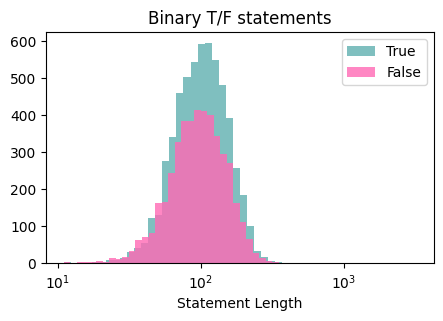

In [27]:
plt.figure(figsize=(5, 3))
plt.hist(np.log10(train_data_bin[train_data_bin['label']==1]['statement'].apply(lambda x: len(x)).values), bins=50,color='teal',alpha=0.5)
plt.hist(np.log10(train_data_bin[train_data_bin['label']==0]['statement'].apply(lambda x: len(x)).values), bins=50,color='hotpink',alpha=0.8)
plt.legend(['True', 'False'])
plt.xticks(np.arange(1, 4, 1), [f'$10^{i}$' for i in range(1,4)])
plt.xlabel('Statement Length')
plt.title('Binary T/F statements')
plt.show()

#### Meta Data Analysis

In [28]:
train_data_bin.groupby('speaker').agg(
    true_percentage_bin=('label', 'mean'),
    frequency=('speaker', 'count')
).sort_values(by='frequency',ascending=False).head(10)


,true_percentage_bin,frequency
speaker,,
barack-obama,0.731557,488
donald-trump,0.263736,273
hillary-clinton,0.736402,239
mitt-romney,0.590909,176
scott-walker,0.563758,149
john-mccain,0.574324,148
rick-perry,0.521127,142
chain-email,0.119718,142
marco-rubio,0.581197,117


In [29]:
train_data_bin.groupby('party_affiliation').agg(
    true_percentage_bin=('label', 'mean'),
    frequency=('speaker', 'count')
).sort_values(by='frequency',ascending=False).head(10)


,true_percentage_bin,frequency
party_affiliation,,
republican,0.501890,4497
democrat,0.662170,3336
none,0.509174,1744
organization,0.488584,219
independent,0.727891,147
newsmaker,0.660714,56
libertarian,0.675000,40
activist,0.641026,39
journalist,0.578947,38


In [30]:
train_data_bin.groupby('state_info').agg(
    true_percentage_bin=('label', 'mean'),
    frequency=('speaker', 'count')
).sort_values(by='frequency',ascending=False).head(10)


,true_percentage_bin,frequency
state_info,,
Texas,0.537166,1009
Florida,0.598796,997
Wisconsin,0.509116,713
New York,0.497717,657
Illinois,0.714029,556
Ohio,0.673378,447
Georgia,0.629108,426
Virginia,0.552826,407
Rhode Island,0.582656,369


### Crude Text Preprocessing withouth using any metadata

In [31]:
from sklearn.model_selection import train_test_split

X_train, y_train = train_data_bin['statement'], train_data_bin['label']
X_test, y_test = test_data_bin['statement'], test_data_bin['label']

In [32]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_features=1000)
X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)



In [33]:
X_train[0]

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 8 stored elements and shape (1, 1000)>

Binary evalutions look too high for such a simple model

I'll try 6 way

In [34]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, f1_score
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV

In [35]:
model = SVC()
model = MultinomialNB()
#model = LogisticRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

print(f'Acc:\t{accuracy_score(y_test, y_pred):.3}')
print(f'F1:\t{f1_score(y_test, y_pred):.3}')

              precision    recall  f1-score   support

           0       0.58      0.39      0.47       553
           1       0.62      0.78      0.70       714

    accuracy                           0.61      1267
   macro avg       0.60      0.59      0.58      1267
weighted avg       0.61      0.61      0.60      1267

Acc:	0.613
F1:	0.696


In [36]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_test, y_pred)[::-1, ::-1]

array([[560, 154],
       [336, 217]])

### 6-way Classification

In [37]:
train_data_6= binarize_labels(train_data,True)
test_data_6= binarize_labels(test_data,True)
valid_data_6= binarize_labels(valid_data,True)

In [40]:
X_train_6, y_train_6= train_data_6['statement'], train_data_6['label']
X_test_6, y_test_6= test_data_6['statement'], test_data_6['label']


In [41]:
vectorizer = TfidfVectorizer(max_features=1000)
X_train_6 = vectorizer.fit_transform(X_train_6)
X_test_6 = vectorizer.fit_transform(X_test_6)


In [67]:
model= MultinomialNB()
#model= SVC()
model= LogisticRegression()
#model= LogisticRegressionCV()
model.fit(X_train_6, y_train_6)

y_pred_6= model.predict(X_test_6)

print(classification_report(y_test_6, y_pred_6))

print(f'Acc:\t{accuracy_score(y_test_6, y_pred_6):.3}')
print(f'F1:\t{f1_score(y_test_6, y_pred_6,average="weighted"):.3}')

              precision    recall  f1-score   support

           0       0.09      0.02      0.03        92
           1       0.19      0.20      0.20       249
           2       0.18      0.17      0.17       212
           3       0.26      0.37      0.30       265
           4       0.19      0.20      0.19       241
           5       0.16      0.12      0.14       208

    accuracy                           0.20      1267
   macro avg       0.18      0.18      0.17      1267
weighted avg       0.19      0.20      0.19      1267

Acc:	0.204
F1:	0.194


Much more realistic result, 

Would this mean that binary classification performance is also accurate?

### Hugging Face Transformers

In [4]:
from transformers import pipeline

classifier = pipeline("sentiment-analysis")
classifier("We are very happy to show you the 🤗 Transformers library.")

No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision 714eb0f (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
Device set to use mps:0


[{'label': 'POSITIVE', 'score': 0.9997795224189758}]

In [ ]:
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification

tokenizer = AutoTokenizer.from_pretrained("answerdotai/ModernBERT-base")
model = AutoModelForSequenceClassification.from_pretrained("answerdotai/ModernBERT-base")

In [11]:
from huggingface_hub import whoami

user = whoami()
user

{'type': 'user',
 'id': '6776698fe57a4c8f9e6678a3',
 'name': 'demiraslan',
 'fullname': 'murat',
 'email': 'demiraslanmurat21@gmail.com',
 'emailVerified': True,
 'canPay': False,
 'periodEnd': None,
 'isPro': False,
 'avatarUrl': 'https://cdn-avatars.huggingface.co/v1/production/uploads/no-auth/Zxowvn5oyf3JgjQgPaENx.png',
 'orgs': [],
 'auth': {'type': 'access_token',
  'accessToken': {'displayName': 'first',
   'role': 'read',
   'createdAt': '2025-01-02T12:02:36.899Z'}}}

In [116]:
from datasets import load_dataset, Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
import numpy as np
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

#model_name = "bert-base-uncased"
model_name = "distilbert-base-uncased-finetuned-sst-2-english"

#Step 2: Load Pre-trained Tokenizer and Model
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=6, ignore_mismatched_sizes=True)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased-finetuned-sst-2-english and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([2]) in the checkpoint and torch.Size([6]) in the model instantiated
- classifier.weight: found shape torch.Size([2, 768]) in the checkpoint and torch.Size([6, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [117]:
train_data_6

,id,label,statement,subjects,speaker,speaker_job_title,state_info,party_affiliation,context
0,2635.json,1,Says the Annies List political group supports ...,abortion,dwayne-bohac,State representative,Texas,republican,a mailer
1,10540.json,3,When did the decline of coal start? It started...,"energy,history,job-accomplishments",scott-surovell,State delegate,Virginia,democrat,a floor speech.
2,324.json,4,"Hillary Clinton agrees with John McCain ""by vo...",foreign-policy,barack-obama,President,Illinois,democrat,Denver
3,1123.json,1,Health care reform legislation is likely to ma...,health-care,blog-posting,NaN,NaN,none,a news release
4,9028.json,3,The economic turnaround started at the end of ...,"economy,jobs",charlie-crist,NaN,Florida,democrat,an interview on CNN
...,...,...,...,...,...,...,...,...,...
10235,5473.json,4,There are a larger number of shark attacks in ...,"animals,elections",aclu-florida,NaN,Florida,none,"interview on ""The Colbert Report"""
10236,3408.json,4,Democrats have now become the party of the [At...,elections,alan-powell,NaN,Georgia,republican,an interview
10237,3959.json,3,Says an alternative to Social Security that op...,"retirement,social-security",herman-cain,NaN,Georgia,republican,a Republican presidential debate
10238,2253.json,1,On lifting the U.S. Cuban embargo and allowing...,"florida,foreign-policy",jeff-greene,NaN,Florida,democrat,a televised debate on Miami's WPLG-10 against ...


In [118]:
train_data_6 = train_data_6[["statement", "label"]]
test_data_6 = test_data_6[["statement", "label"]]
valid_data_6 = valid_data_6[["statement", "label"]]

# Step 1: Combine DataFrames
concat_dfs = pd.concat([train_data_6, test_data_6, valid_data_6])  # Ensure all inputs are pandas DataFrames

# Step 2: Convert to Hugging Face Dataset
dataset = Dataset.from_pandas(concat_dfs)

# Step 3: Preprocess the Dataset
def preprocess_function(examples):
    return tokenizer(examples["statement"], padding="max_length", truncation=True, max_length=512)

encoded_dataset = dataset.map(preprocess_function, batched=True)


Map: 100%|██████████| 12791/12791 [00:01<00:00, 11104.25 examples/s]


In [119]:
# Step 4: Split the Dataset
splitted_dataset = encoded_dataset.train_test_split(test_size=0.2)
train_dataset = splitted_dataset["train"]
#train_dataset = splitted_dataset["train"].shuffle(42).select(range(300))

evalll_dataset = splitted_dataset["test"].train_test_split(test_size=0.5)
val_dataset = evalll_dataset['train']
test_dataset = evalll_dataset['test']
#val_dataset = evalll_dataset['train'].shuffle(42).select(range(300))
#test_dataset = evalll_dataset['test'].shuffle(42).select(range(300))

In [120]:
train_dataset

Dataset({
    features: ['statement', 'label', '__index_level_0__', 'input_ids', 'attention_mask'],
    num_rows: 10232
})

In [121]:
evalll_dataset

DatasetDict({
    train: Dataset({
        features: ['statement', 'label', '__index_level_0__', 'input_ids', 'attention_mask'],
        num_rows: 1279
    })
    test: Dataset({
        features: ['statement', 'label', '__index_level_0__', 'input_ids', 'attention_mask'],
        num_rows: 1280
    })
})

In [125]:
# Step 6: Define Metrics for Evaluation
def compute_metrics(pred):
    logits, labels = pred
    predictions = np.argmax(logits, axis=-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average="weighted")
    acc = accuracy_score(labels, predictions)
    return {"accuracy": acc, "f1": f1, "precision": precision, "recall": recall}

training_args = TrainingArguments(
    output_dir="./results",           # Directory to save the model
    evaluation_strategy="epoch",     # Evaluate at the end of each epoch
    save_strategy="epoch",           # Save model at the end of each epoch
    #learning_rate=2e-5,              # Learning rate
    learning_rate=1e-5,                 # Learning rate
    per_device_train_batch_size=8,   # Batch size for training
    per_device_eval_batch_size=8,    # Batch size for evaluation
    num_train_epochs=3,              # Number of epochs
    weight_decay=0.01,               # Weight decay
    logging_dir="./logs",            # Directory for logging
    logging_steps=10,                # Log every 10 steps
    load_best_model_at_end=True,     # Load the best model at the end of training
    save_total_limit=2               # Limit the number of saved models
)

# Step 8: Initialize Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)


/Users/muratdemiraslan/Out Cloud Files/GitHub/CS445_Fake_News_detection/.venv/lib/python3.12/site-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/var/folders/9y/95mkwd2510d9nppjdk99shfm0000gn/T/ipykernel_17255/1574493767.py:26: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [ ]:
# Step 9: Train the Model
trainer.train()

# Step 10: Evaluate the Model
results = trainer.evaluate()
print(f'results: {results}')

In [127]:
trainer.save_model("./results/model_distil_bert")

In [ ]:
model_path = "./results/model_bert" # Path to the saved model
model = AutoModelForSequenceClassification.from_pretrained(model_path)

# Step 11: Make Predictions
test_results = trainer.evaluate(test_dataset)
print(f'test_results: {test_results}')

195it [01:31,  2.14it/s]                         

test_results: {'eval_loss': 1.6828114986419678, 'eval_accuracy': 0.265625, 'eval_f1': 0.2445776514783559, 'eval_precision': 0.2822659542800012, 'eval_recall': 0.265625, 'eval_runtime': 62.7461, 'eval_samples_per_second': 20.4, 'eval_steps_per_second': 2.55, 'epoch': 3.0}


In [128]:
model_path = "./results/model_distil_bert" # Path to the saved model
model = AutoModelForSequenceClassification.from_pretrained(model_path)

# Step 11: Make Predictions
test_results = trainer.evaluate(test_dataset)
print(f'test_results: {test_results}')

100%|██████████| 160/160 [00:31<00:00,  5.10it/s]

test_results: {'eval_loss': 1.6839221715927124, 'eval_accuracy': 0.28046875, 'eval_f1': 0.2532648974063987, 'eval_precision': 0.26991166180723286, 'eval_recall': 0.28046875, 'eval_runtime': 32.5109, 'eval_samples_per_second': 39.371, 'eval_steps_per_second': 4.921, 'epoch': 3.0}
